In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import os
%matplotlib inline
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [2]:
train_data = pd.read_csv('SolarPrediction.csv',index_col=0)

In [3]:
train_data.head()

,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
UNIXTime,,,,,,,,,,
1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results
The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
The date in yyyy-mm-dd format
The local time of day in hh:mm:ss 24-hour format
The numeric data, if any (may be an empty string)
The text data, if any (may be an empty string)

The units of each dataset are:

Solar radiation: watts per meter^2

Temperature: degrees Fahrenheit

Humidity: percent

Barometric pressure: Hg

Wind direction: degrees

Wind speed: miles per hour

Sunrise/sunset: Hawaii time

In [4]:
train_data.dtypes

Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

In [5]:
train_data.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


To predict level of solar radiation.

In [6]:
train_data['Radiation'].describe()

count    32686.000000
mean       207.124697
std        315.916387
min          1.110000
25%          1.230000
50%          2.660000
75%        354.235000
max       1601.260000
Name: Radiation, dtype: float64

In [7]:
train_data['Speed'] = train_data['Speed'] * 1.6093

#-17.222222

In [8]:
a = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
train_missing= pd.concat([a, percent], axis=1, keys=['Total', 'Percent'])
train_missing.head(20)

,Total,Percent
Data,0,0.0
Time,0,0.0
Radiation,0,0.0
Temperature,0,0.0
Pressure,0,0.0
Humidity,0,0.0
WindDirection(Degrees),0,0.0
Speed,0,0.0
TimeSunRise,0,0.0
TimeSunSet,0,0.0


No missing data

In [9]:
train_data.index

Int64Index([1475229326, 1475229023, 1475228726, 1475228421, 1475228124,
            1475227824, 1475227519, 1475227222, 1475226922, 1475226622,
            ...
            1480589102, 1480588802, 1480588503, 1480588205, 1480587902,
            1480587604, 1480587301, 1480587001, 1480586702, 1480586402],
           dtype='int64', name='UNIXTime', length=32686)

Feature Engineering

<AxesSubplot:>

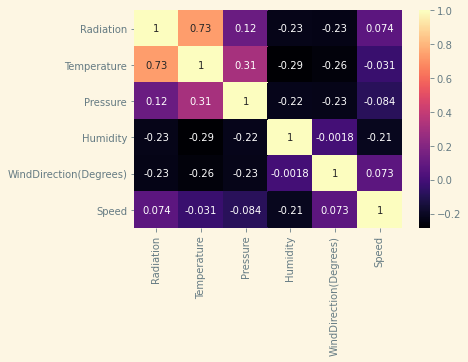

In [10]:
# Check correlation

corr_matrix=train_data.corr()
sns.heatmap(corr_matrix,cmap='magma',annot=True)

In [11]:
train_data = train_data.reindex(np.random.permutation(train_data.index))

In [29]:
def process_features(dataset):
    
    features_to_use = dataset.loc[:,['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']]
    ready_to_use = features_to_use.copy()
    
    return ready_to_use

def process_single_prediction(s):
    g=s.copy()
    
    f=list(g)
    g_f = dict()
    for i in list(g):
     
        g_f['Temperature'] = f[0]
        g_f['Pressure'] = f[1]
        g_f['Humidity'] = f[2]
        g_f['WindDirection(Degrees)'] = f[3]
        g_f['Speed'] = f[4]
                   
    g_f=pd.DataFrame(data=[g_f.values()],columns=['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed'])    
    
    g_f.loc[1,['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']]=train_data.loc[1479722402,['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']]
   
    return g_f

h=train_data.loc[ 1477567221,['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']]
process_single_prediction(h)

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,45.0,30.41,66.0,141.27,12.665191
1,45.0,30.44,96.0,129.59,14.483700


In [13]:
train_dataset = train_data.sample(frac=0.8, random_state= 121)
test_dataset = train_data.drop(train_dataset.index)

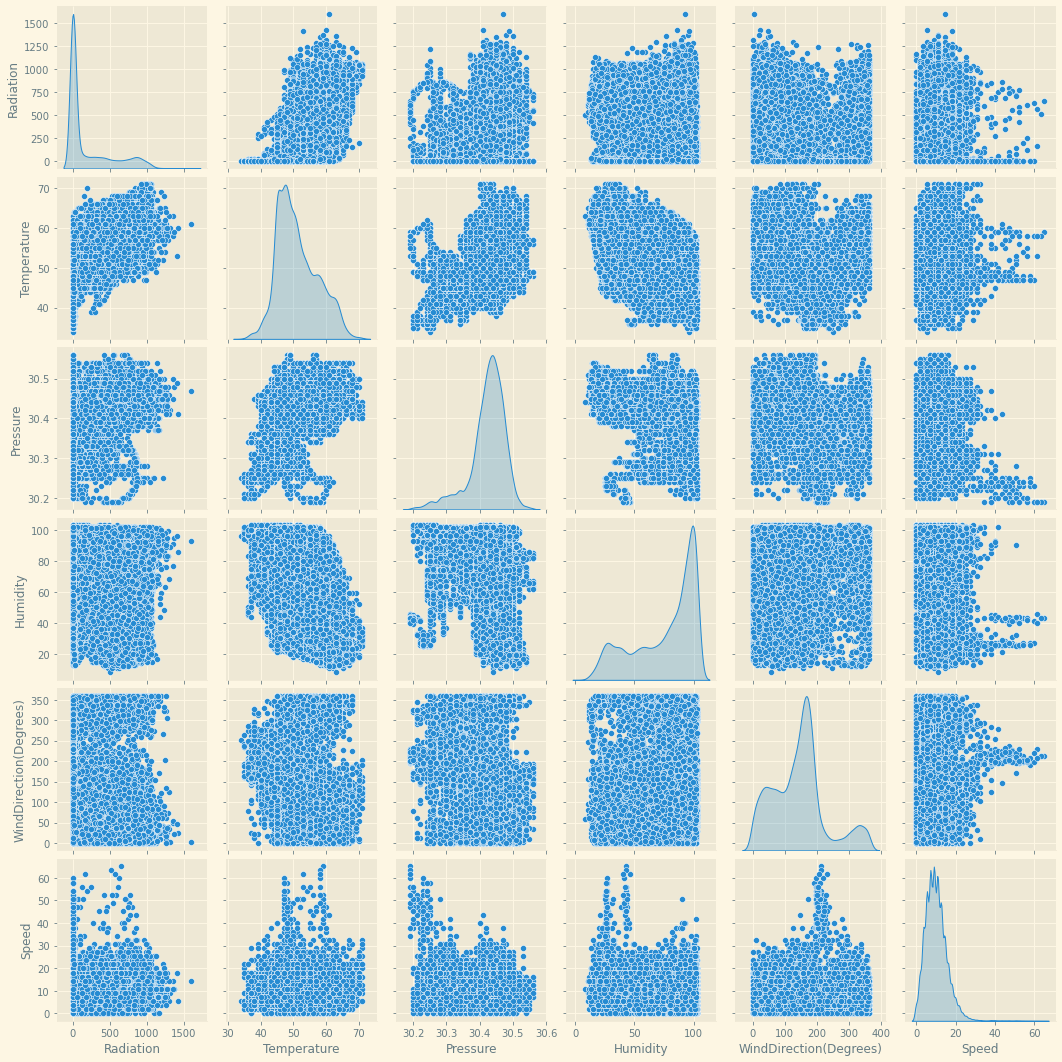

In [14]:
sns.pairplot(train_dataset[['Radiation','Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']], diag_kind='kde')

In [30]:
train_features = process_features(train_dataset)
test_features = process_features(test_dataset)

train_labels = train_dataset['Radiation']
test_labels = test_dataset['Radiation']

feature_cols = [tf.feature_column.numeric_column(my_feature)for my_feature in train_features]

In [31]:
def model_input(option,batch_size=0,num_epochs=None, shuffle=True):
    
    if option == 'train':
        return tf.compat.v1.estimator.inputs.pandas_input_fn(
        x = train_features,
        y = train_labels,
        
        batch_size = batch_size,
        num_epochs=num_epochs,
        shuffle=shuffle
        )
    
    if option == 'evaluate':
        return tf.compat.v1.estimator.inputs.pandas_input_fn(
        x = test_features,
        y = test_labels,
       
        batch_size=batch_size,
        num_epochs=num_epochs,
        shuffle=shuffle
        )
    
def prediction_input(data,num_epochs=None,shuffle=True):
   
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
    x = data,
    num_epochs=num_epochs,
    shuffle=shuffle
    )

In [32]:
radiation_linear_estimator = tf.estimator.LinearRegressor(
     feature_columns=feature_cols,
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MELVIN~1\\AppData\\Local\\Temp\\tmp1532ffe5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}



Commencing model training...

INFO:tensorflow:Calling model_fn.


C:\Users\Melvin Wepukhulu\anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\MELVIN~1\AppData\Local\Temp\tmp1532ffe5\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 161326.56, step = 0
INFO:tensorflow:global_step/sec: 380.359
INFO:tensorflow:loss = 111764.875, step = 100 (0.263 sec)
INFO:tensorflow:global_step/sec: 356.238
INFO:tensorflow:loss = 84797.15, step = 200 (0.285 sec)
INFO:tensorflow:global_step/sec: 382.034
INFO:tensorflow:loss = 81161.37, step = 300 (0.262 sec)
INFO:tensorflow:global_step/sec: 412.192
INFO:tensorflow:loss = 88571.42, step = 400 (0.247 sec)
INFO:tensorflow:global_step/sec: 398.139
INFO:tensorflow:loss = 95651.04, step = 500 (0.245 sec)
INFO:tensor

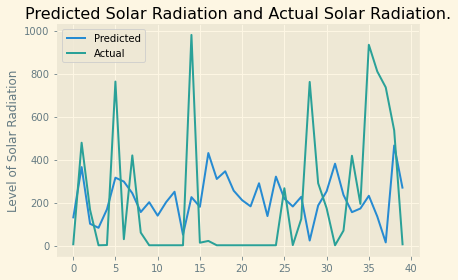

In [33]:
print('\nCommencing model training...\n')
radiation_linear_estimator.train(input_fn=model_input('train',batch_size=128,num_epochs=None), steps=10_00)

inputFn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
tf.feature_column.make_parse_example_spec(feature_cols))

OUTDIR = 'rad_linear regression'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
modelBasePath = os.path.join(OUTDIR, 'model')
modelPath = radiation_linear_estimator.export_saved_model(modelBasePath, inputFn)
print('Model training done.\n')


evaluation = radiation_linear_estimator.evaluate(input_fn=model_input('evaluate',batch_size=20,num_epochs=10))
print(evaluation,'\n')



test_predictions = radiation_linear_estimator.predict(input_fn=prediction_input(data=test_features,num_epochs=1))
test_predictions = [item['predictions'][0] for item in test_predictions]

print('rmse when using training data:')

linear_rmse = mean_squared_error(test_dataset['Radiation'],test_predictions,squared=False)

print(linear_rmse,'\n')


x=list(test_dataset['Radiation'])
plt.ylabel('Level of Solar Radiation')

plt.title('Predicted Solar Radiation and Actual Solar Radiation.')
plt.tight_layout()
plt.plot(test_predictions[0:40], label='Predicted')
plt.plot(x[0:40], label='Actual')
plt.legend()


In [22]:
savedModelPath = modelPath
importedModel = tf.saved_model.load(savedModelPath)

def predict(dfeval, importedModel):
    colNames = dfeval.columns
    dtypes = dfeval.dtypes
    predictions = list()
    for row in dfeval.iterrows():
        example = tf.train.Example()
        for i in range(len(colNames)):
           dtype = dtypes[i]
           colName = colNames[i]
           value = row[1][colName]
           if dtype == "object":
                value = bytes(value, "utf-8")
                example.features.feature[colName].bytes_list.value.extend(
                    [value])
           elif dtype == "float":
                example.features.feature[colName].float_list.value.extend(
                    [value])
           elif dtype == "int":
                example.features.feature[colName].int64_list.value.extend(
                    [value])

        predictions.append(
          importedModel.signatures["predict"](
            examples=tf.constant([example.SerializeToString()])))
        
    return predictions

#testing
j=train_data.loc[1482368149,['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']]
x=predict(process_single_prediction(j),importedModel)

# x[0]['predictions'][0][0]

float(x[0]['predictions'][0][0])

346.9947204589844

In [23]:
train_data.loc[1482368149,'Radiation']

613.42